#### 1. Import Libraries and Define Paths

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


base_dir = "C:\Users\nacha\Downloads\archive (2)\marine-animals-dataset\versions\1"
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')


#### Visulatization of input

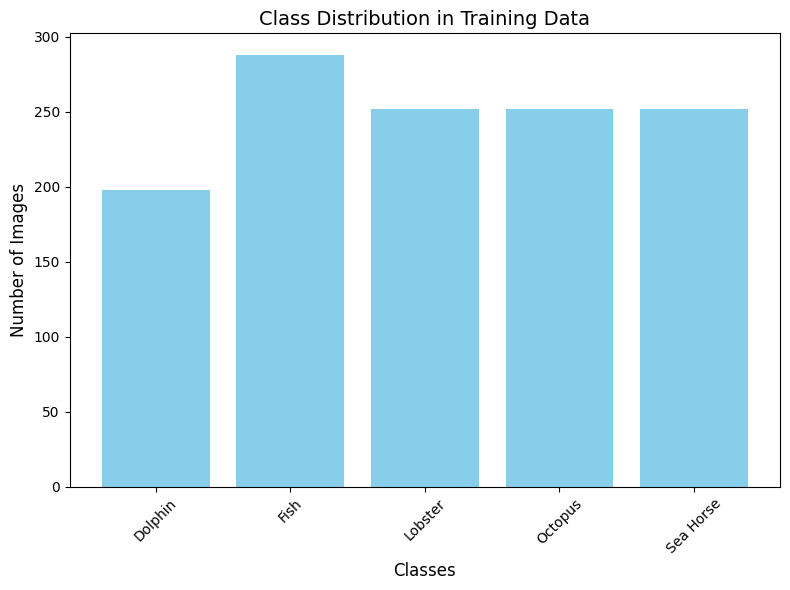

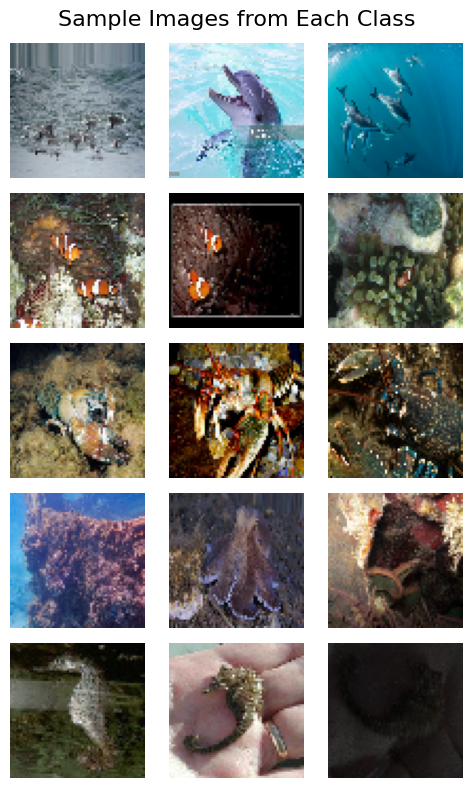

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def resize_image_manual(img, size=(64, 64)):
    h, w = img.shape[0], img.shape[1]
    new_h, new_w = size
    resized = np.zeros((new_h, new_w, img.shape[2]), dtype=img.dtype)
    
    for i in range(new_h):
        for j in range(new_w):
            orig_x = int(i * h / new_h)
            orig_y = int(j * w / new_w)
            resized[i, j] = img[orig_x, orig_y]
    return resized

def visualize_dataset_manual(directory, num_samples=3):
   
    class_counts = {}
    classes = []
    
    for item in os.listdir(directory):
        class_path = os.path.join(directory, item)
        if os.path.isdir(class_path):
            classes.append(item)
            count = 0
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    count = count + 1
            class_counts[item] = count
    
   
    plt.figure(figsize=(8, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title("Class Distribution in Training Data", fontsize=14)
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    
    plt.figure(figsize=(5, 8))
    
    row_index = 0
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        sample_images = os.listdir(class_dir)[:num_samples]
        
        col_index = 0
        for img_name in sample_images:
            img_path = os.path.join(class_dir, img_name)
            try:
                img = mpimg.imread(img_path)  
                if img.shape[0] > 64 or img.shape[1] > 64:
                    img = resize_image_manual(img, (64, 64))  
                
                subplot_index = row_index * num_samples + col_index + 1
                plt.subplot(len(classes), num_samples, subplot_index)
                plt.imshow(img)
                plt.axis('off')
                
                if col_index == 0:
                    plt.ylabel(cls, fontsize=12)
                
                col_index = col_index + 1
            except Exception as e:
                print("Error loading:", img_path, "|", e)
        
        row_index = row_index + 1
    
    plt.suptitle("Sample Images from Each Class", fontsize=16)
    plt.tight_layout()
    plt.show()



visualize_dataset_manual(train_dir)

#### 2. Load and Preprocess Data

In [ ]:
import os
import numpy as np
import matplotlib.image as mpimg


VALID_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".gif")


def resize_image_manual(img, size=(128, 128)):
    h, w = img.shape[0], img.shape[1]

    
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)
    elif img.ndim == 3 and img.shape[2] == 1:  
        img = np.concatenate([img, img, img], axis=2)
    elif img.ndim == 3 and img.shape[2] == 4:  
        img = img[:, :, :3]

    new_h, new_w = size
    resized = np.zeros((new_h, new_w, 3), dtype=img.dtype)

    for i in range(new_h):
        orig_x = int(i * h / new_h)
        if orig_x >= h:
            orig_x = h - 1
        for j in range(new_w):
            orig_y = int(j * w / new_w)
            if orig_y >= w:
                orig_y = w - 1
            resized[i, j] = img[orig_x, orig_y]

    return resized


def load_images_from_directory(directory, target_size=(128, 128)):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory not found: {directory}")

    images = []
    labels = []
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])

    for cls in classes:
        class_dir = os.path.join(directory, cls)
        file_names = sorted([f for f in os.listdir(class_dir) if f.lower().endswith(VALID_EXTS)])
        for fname in file_names:
            img_path = os.path.join(class_dir, fname)
            try:
                img = mpimg.imread(img_path)

              
                img_resized = resize_image_manual(img, target_size).astype(np.float32)
                if img_resized.max() > 1.0:
                    img_resized /= 255.0

                images.append(img_resized)
                labels.append(cls)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")

    if len(images) == 0:
        return np.zeros((0, target_size[0], target_size[1], 3), dtype=np.float32), np.array([], dtype=object), classes

    return np.stack(images, axis=0), np.array(labels, dtype=object), classes


def build_label_map(classes):
    return {cls: idx for idx, cls in enumerate(classes)}

def encode_with_map(labels, label_map):
    return np.array([label_map[lbl] for lbl in labels], dtype=np.int32)


if __name__ == "__main__":
    X_train, y_train_raw, train_classes = load_images_from_directory(train_dir)
    X_valid, y_valid_raw, valid_classes = load_images_from_directory(valid_dir)
    X_test,  y_test_raw,  test_classes  = load_images_from_directory(test_dir)

    print(f"Found {len(X_train)} images belonging to {len(train_classes)} classes.")
    print(f"Found {len(X_valid)} images belonging to {len(valid_classes)} classes.")
    print(f"Found {len(X_test)} images belonging to {len(test_classes)} classes.")

    

Found 1241 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


#### 3. Standardize Data

In [ ]:

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)


std[std == 0] = 1.0  

X_train_scaled = (X_train - mean) / std
X_valid_scaled = (X_valid - mean) / std
X_test_scaled = (X_test - mean) / std

#### 4. Train Random Forest Classifier

In [ ]:


class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        
    def _gini(self, y):
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def _gini_gain(self, y, y_left, y_right):
        if len(y_left) == 0 or len(y_right) == 0:
            return 0
        p_left = len(y_left) / len(y)
        p_right = len(y_right) / len(y)
        gain = self._gini(y) - (p_left * self._gini(y_left) + p_right * self._gini(y_right))
        return gain
    
    def _find_best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        n_samples, n_features = X.shape
        
        for feature_idx in range(n_features):
            feature_values = np.unique(X[:, feature_idx])
            
            for threshold in feature_values:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = X[:, feature_idx] > threshold
                
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                gain = self._gini_gain(y, y_left, y_right)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        
        if (len(np.unique(y)) == 1 or 
            len(y) < self.min_samples_split or 
            (self.max_depth is not None and depth >= self.max_depth)):
            return self._make_leaf_node(y)
        
        feature, threshold, gain = self._find_best_split(X, y)
        
        if gain == -1 or feature is None:
            return self._make_leaf_node(y)
        
        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold
        
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return {
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree,
            'gain': gain
        }
    
    def _make_leaf_node(self, y):
        counts = np.bincount(y, minlength=len(self.classes_))
        total = len(y)
        probabilities = counts / total if total > 0 else np.zeros(len(self.classes_))
        prediction = np.argmax(counts) if total > 0 else 0
        
        return {
            'type': 'leaf',
            'prediction': prediction,
            'probabilities': probabilities,
            'samples': total
        }
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.tree = self._build_tree(X, y)
        return self
    
    def _predict_single(self, x, node):
        if node['type'] == 'leaf':
            return node['prediction']
        
        if x[node['feature']] <= node['threshold']:
            return self._predict_single(x, node['left'])
        else:
            return self._predict_single(x, node['right'])
    
    def _predict_proba_single(self, x, node):
        if node['type'] == 'leaf':
            return node['probabilities']
        
        if x[node['feature']] <= node['threshold']:
            return self._predict_proba_single(x, node['left'])
        else:
            return self._predict_proba_single(x, node['right'])
    
    def predict(self, X):
        return np.array([self._predict_single(x, self.tree) for x in X])
    
    def predict_proba(self, X):
        probas = np.array([self._predict_proba_single(x, self.tree) for x in X])
        return probas

class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.classes_ = None
        
    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]
    
    def _feature_subsampling(self, n_features):
        n_selected = int(math.sqrt(n_features))
        return np.random.choice(n_features, n_selected, replace=False)
    
    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        
        self.trees = []
        for i in range(self.n_estimators):
            X_bootstrap, y_bootstrap = self._bootstrap_sample(X, y)
            
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf
            )
            
            feature_indices = self._feature_subsampling(n_features)
            X_subset = X_bootstrap[:, feature_indices]
            
            tree.fit(X_subset, y_bootstrap)
            tree.feature_indices = feature_indices
            self.trees.append(tree)
        
        return self
    
    def predict(self, X):
        all_predictions = []
        for tree in self.trees:
            X_subset = X[:, tree.feature_indices]
            predictions = tree.predict(X_subset)
            all_predictions.append(predictions)
        
        all_predictions = np.array(all_predictions)
        final_predictions = []
        
        for sample_idx in range(X.shape[0]):
            sample_predictions = all_predictions[:, sample_idx]
            most_common = Counter(sample_predictions).most_common(1)[0][0]
            final_predictions.append(most_common)
        
        return np.array(final_predictions)
    
    def predict_proba(self, X):
        all_probas = []
        for tree in self.trees:
            X_subset = X[:, tree.feature_indices]
            probas = tree.predict_proba(X_subset)
            all_probas.append(probas)
        
        all_probas = np.array(all_probas)
        avg_probas = np.mean(all_probas, axis=0)
        return avg_probas

RandomForestClassifier(n_jobs=-1, random_state=42)

#### 5. Evaluate the Model

In [ ]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def classification_report(y_true, y_pred, target_names):
    n_classes = len(target_names)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    for true, pred in zip(y_true, y_pred):
        cm[true][pred] += 1
    
    print("              precision    recall  f1-score   support")
    print("")
    
    for i in range(n_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = np.sum(cm) - tp - fp - fn
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        support = np.sum(cm[i, :])
        
        print(f"{target_names[i]:<15} {precision:.2f}       {recall:.2f}      {f1:.2f}       {support}")
    
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    print(f"\naccuracy:                            {accuracy:.2f}      {np.sum(cm)}")

y_val_pred = rf_clf.predict(X_valid)
val_accuracy = accuracy_score(y_valid, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

y_test_pred = rf_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

print("\nClassification Report (Test Data):")
class_names = list(train_data.class_indices.keys())
print(classification_report(y_test, y_test_pred, target_names=class_names))

Validation Accuracy: 0.43
Test Accuracy: 0.42

Classification Report (Test Data):
              precision    recall  f1-score   support

     Dolphin       0.61      0.85      0.71        20
        Fish       0.25      0.30      0.27        20
     Lobster       0.47      0.35      0.40        20
     Octopus       0.33      0.30      0.32        20
   Sea Horse       0.40      0.30      0.34        20

    accuracy                           0.42       100
   macro avg       0.41      0.42      0.41       100
weighted avg       0.41      0.42      0.41       100



#### 6. Feature Importance (Optional)

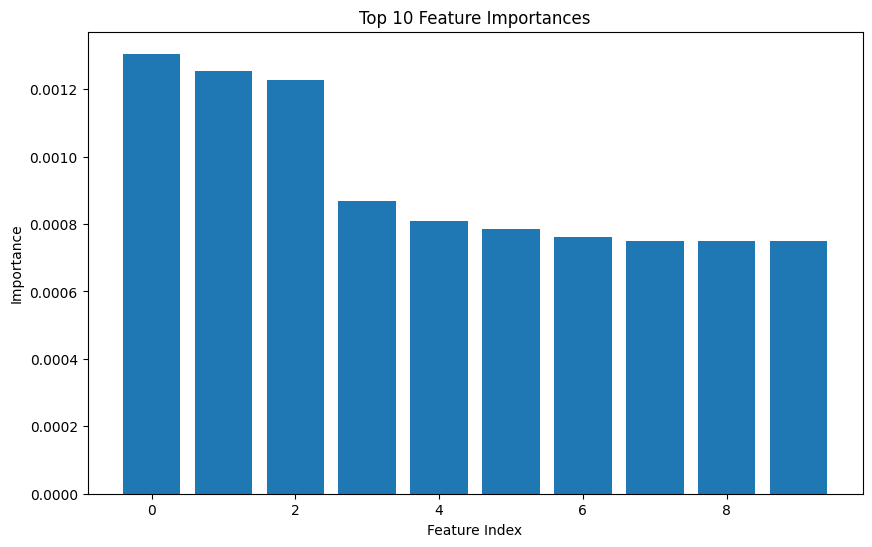

In [ ]:
import matplotlib.pyplot as plt

def compute_feature_importances(clf, n_features):
    importances = np.zeros(n_features)
    for tree in clf.trees:
        def traverse(node):
            if hasattr(node, "feature") and node.feature is not None:
                importances[node.feature] += 1
                traverse(node.left)
                traverse(node.right)
        traverse(tree.tree)
    importances /= importances.sum()
    return importances

importances = compute_feature_importances(clf, X_train.shape[1])


top_indices = np.argsort(importances)[::-1][:10]
top_importances = importances[top_indices]


plt.figure(figsize=(10, 6))
bars = plt.bar(range(10), top_importances, color='skyblue')

plt.title('Top 10 Feature Importances', fontsize=14)
plt.xlabel('Feature Index', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.xticks(range(10), top_indices, fontsize=10)
plt.yticks(fontsize=10)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

#### Apply PCA for Dimensionality Reduction

In [ ]:

def manual_pca(X, n_components):
    # Step 1: Center the data
    X_mean = np.mean(X, axis=0)
    X_meaned = X - X_mean

    # Step 2: Covariance matrix
    cov_matrix = np.cov(X_meaned, rowvar=False)

    # Step 3: Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Step 4: Sort eigenvalues (descending) and select top n_components
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]

    # Step 5: Choose top components
    eigenvectors_subset = eigenvectors[:, :n_components]
    eigenvalues_subset = eigenvalues[:n_components]

    # Step 6: Project data
    X_reduced = np.dot(X_meaned, eigenvectors_subset)

    
    explained_variance_ratio = eigenvalues_subset / np.sum(eigenvalues)

    return X_reduced, eigenvectors_subset, X_mean, explained_variance_ratio


def manual_pca_transform(X, components, mean_vec):
    X_meaned = X - mean_vec
    return np.dot(X_meaned, components)


X_train = flatten_data(X_train)
X_valid = flatten_data(X_valid)
X_test  = flatten_data(X_test)

n_components = 500

X_train_pca, pca_components, train_mean, explained_var_ratio = manual_pca(X_train, n_components)

X_valid_pca = manual_pca_transform(X_valid, pca_components, train_mean)
X_test_pca  = manual_pca_transform(X_test, pca_components, train_mean)

print(f"Original feature size: {X_train.shape[1]}")
print(f"Reduced feature size: {X_train_pca.shape[1]}")



Original feature size: 49152
Reduced feature size: 500


In [ ]:
rf_clf = RandomForest(n_estimators=100, random_state=42)

rf_clf.fit(X_train_pca, y_train)

y_valid_pred = rf_clf.predict(X_valid_pca)
val_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy after PCA: {val_accuracy:.2f}")

y_test_pred = rf_clf.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy after PCA: {test_accuracy:.2f}")

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred))

Validation Accuracy after PCA: 0.31
Test Accuracy after PCA: 0.38

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.55      0.85      0.67        20
           1       0.31      0.20      0.24        20
           2       0.50      0.40      0.44        20
           3       0.25      0.25      0.25        20
           4       0.20      0.20      0.20        20

    accuracy                           0.38       100
   macro avg       0.36      0.38      0.36       100
weighted avg       0.36      0.38      0.36       100



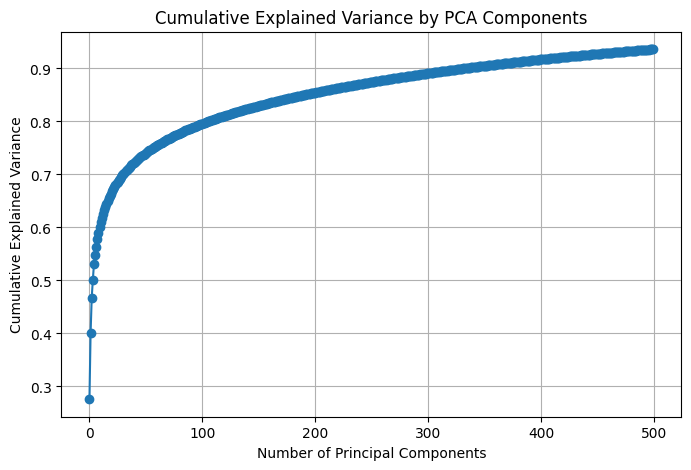

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_variance >= 0.99) + 1
print(f"Optimal number of components for 99% variance: {optimal_components}")

pca = PCA(n_components=optimal_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

Optimal number of components for 99% variance: 1


#### 1. Use a Pre-trained Model for Feature Extraction (e.g., VGG16)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os


vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


def extract_features_from_directory(directory):
    features = []
    labels = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=(128, 128))  
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = preprocess_input(img_array)  

                
                feature = vgg_model.predict(img_array)
                feature = feature.flatten()  
                features.append(feature)
                labels.append(class_name)
    
    return np.array(features), np.array(labels)


X_train_features, y_train = extract_features_from_directory(train_dir)
X_valid_features, y_valid = extract_features_from_directory(valid_dir)
X_test_features, y_test = extract_features_from_directory(test_dir)

print(f"Training features shape: {X_train_features.shape}")
print(f"Validation features shape: {X_valid_features.shape}")
print(f"Test features shape: {X_test_features.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━

#### Preprocess the Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)

print(f"Encoded labels: {np.unique(y_train_encoded)}")


Encoded labels: [0 1 2 3 4]


#### Train the Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)


rf_clf.fit(X_train_features, y_train_encoded)


y_valid_pred = rf_clf.predict(X_valid_features)
y_test_pred = rf_clf.predict(X_test_features)


val_accuracy = accuracy_score(y_valid_encoded, y_valid_pred)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


print("\nClassification Report (Test Data):")
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))


Validation Accuracy: 0.72
Test Accuracy: 0.75

Classification Report (Test Data):
              precision    recall  f1-score   support

     Dolphin       0.83      0.95      0.88        20
        Fish       1.00      0.65      0.79        20
     Lobster       0.82      0.70      0.76        20
     Octopus       0.62      0.75      0.68        20
   Sea Horse       0.61      0.70      0.65        20

    accuracy                           0.75       100
   macro avg       0.78      0.75      0.75       100
weighted avg       0.78      0.75      0.75       100



#### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}


grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)


grid_search.fit(X_train_features, y_train_encoded)


print(f"Best Parameters: {grid_search.best_params_}")


best_rf_clf = grid_search.best_estimator_
y_test_pred = best_rf_clf.predict(X_test_features)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

print(f"Test Accuracy after Hyperparameter Tuning: {test_accuracy:.2f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Test Accuracy after Hyperparameter Tuning: 0.78


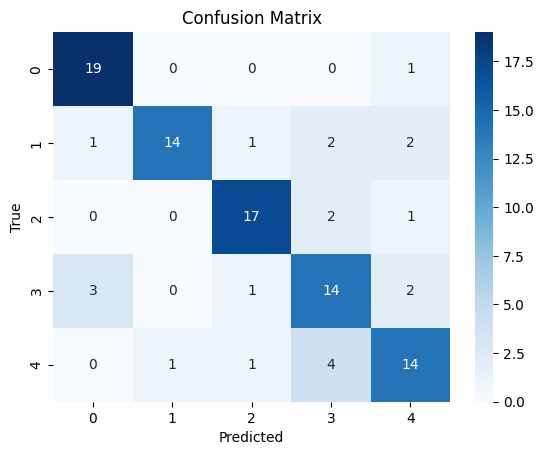

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt


conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
